In [94]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from prophet.python import fbprophet
#from prophet.python.fbprophet import models
#from prophet.python.fbprophet import plot
#from prophet.python.fbprophet import diagnostics

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pkg_resources
import os
from pathlib import Path
import numpy as np
import scipy
from copy import deepcopy
import tqdm

import metrics_refactored

import time
import timeit

In [2]:
from make_datasets import data, datasets, format_for_prophet, dataset_generator

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [3]:
samples = 1000
warmup = 500
fit_kwargs = {'adapt_delta': 0.9, 'max_treedepth': 11, 'adapt_kappa': 0.75}

In [4]:
def initialise_models(samples=1000):
    # Initialize models
    m1 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
    m2 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
    m3 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive', seasonality_prior_scale=1)
    m4 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=20, seasonality_mode='additive', seasonality_prior_scale=1)
    m5 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=False, n_changepoints=1, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)

    for r in ['temperature', 'fuel_price', 'cpi', 'unemployment_interpolated', 'IsHoliday']:
        m2.add_regressor(r)
        
    m3.add_regressor('overfit', standardize=False, prior_scale=10)
    m5.add_regressor('overfit', standardize=False, prior_scale=10)
    return [m1, m2, m3, m4, m5]

In [5]:
def time_model_fits(models):
    dataset = datasets['A']
    fitting_times = []
    for model in models:
        #start_time = time.time()
        #model.fit(dataset, control=fit_kwargs, warmup=warmup)
        #end_time = time.time()
        #fitting_times.append(end_time - start_time)
        f_time = timeit.timeit(lambda: model.fit(dataset, control=fit_kwargs, warmup=warmup), number=1)
        fitting_times.append(f_time)
        print(f_time)
    return fitting_times

In [31]:
thesis_models = initialise_models()
times = time_model_fits(thesis_models)
print(times)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
32.2697019000002
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
59.47043993199986
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
105.54661445099964
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Dis

In [67]:
output = pd.DataFrame(times)
output.index = [f'M{i+1}' for i in range(5)]
output.columns = ['Initial fitting time']
output

,Initial fitting time
M1,32.269702
M2,59.470440
M3,105.546614
M4,65.302322
M5,7.683814


In [6]:
def time_metric_evaluations(models):
    out = []
    for model in models:
        model_times = pd.Series()
        model_times['AIC'] = timeit.timeit(lambda: metrics_refactored.aic(model), number=100)/100.0
        model_times['DIC'] = timeit.timeit(lambda: metrics_refactored.dic(model), number=3)/3.0
        model_times['WAIC'] = timeit.timeit(lambda: metrics_refactored.waic(model), number=100)/100.0
        model_times['MAPE'] = timeit.timeit(lambda: metrics_refactored.defalut_cross_val(model), number=1)
        model_times['10-fold-CV'] = timeit.timeit(lambda: metrics_refactored.k_fold_loo_cv(model), number=1)
        out.append(model_times)
        print(model_times)
    return out

In [56]:
res = time_metric_evaluations(thesis_models)

ipykernel_launcher:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2012-03-30 00:00:00 and 2012-07-13 00:00:00
100%|██████████| 3/3 [01:48<00:00, 36.09s/it]
AIC             0.002073
DIC             8.308994
WAIC            0.004202
MAPE          108.393622
10-fold-CV    358.458327
dtype: float64
INFO:fbprophet:Making 3 forecasts with cutoffs between 2012-03-30 00:00:00 and 2012-07-13 00:00:00
100%|██████████| 3/3 [02:43<00:00, 54.41s/it]
AIC             0.003261
DIC             7.883475
WAIC            0.004125
MAPE          163.330320
10-fold-CV    491.660728
dtype: float64
INFO:fbprophet:Making 3 forecasts with cutoffs between 2012-03-30 00:00:00 and 2012-07-13 00:00:00
100%|██████████| 3/3 [03:23<00:00, 67.86s/it]
AIC             0.007402
DIC             8.059893
WAIC            0.004525
MAPE          203.6802

In [73]:
metric_times_out = pd.DataFrame(res)
metric_times_out.index = output.index
total_out = output.join(metric_times_out)
total_out[['Initial fitting time', 'DIC', 'MAPE', '10-fold-CV']] = total_out[['Initial fitting time', 'DIC', 'MAPE', '10-fold-CV']].round(2)
total_out[['AIC', 'WAIC']] = total_out[['AIC', 'WAIC']].round(5)
total_out.to_csv('../timing_rounded.csv')
total_out

,Initial fitting time,AIC,DIC,WAIC,MAPE,10-fold-CV
M1,32.27,0.00207,8.31,0.00420,108.39,358.46
M2,59.47,0.00326,7.88,0.00412,163.33,491.66
M3,105.55,0.00740,8.06,0.00453,203.68,763.72
M4,65.30,0.00312,7.48,0.00426,151.36,490.07
M5,7.68,0.00376,6.69,0.00453,34.79,83.10


In [78]:
total_out.divide(total_out['Initial fitting time'], axis='rows')

,Initial fitting time,AIC,DIC,WAIC,MAPE,10-fold-CV
M1,1.0,0.000064,0.257515,0.000130,3.358847,11.108150
M2,1.0,0.000055,0.132504,0.000069,2.746427,8.267362
M3,1.0,0.000070,0.076362,0.000043,1.929702,7.235623
M4,1.0,0.000048,0.114548,0.000065,2.317917,7.504900
M5,1.0,0.000490,0.871094,0.000590,4.529948,10.820312


# Stability plots 

---



In [38]:
warmup = 500
samples = 4000
stability_models = initialise_models(samples=samples+warmup)
fast_model = stability_models[4]


In [28]:
data = datasets['A']
#fast_model.fit(datasets['A'], warmup=warmup, control=fit_kwargs)

In [29]:
sweep_res_aic_waic = metrics_refactored.sweep_samples(fast_model, data, warmup=warmup, metrics={'AIC':metrics_refactored.aic, 'WAIC':metrics_refactored.waic}, points=400)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
100%|██████████| 400/400 [01:32<00:00,  4.35it/s]


In [31]:
sweep_res_aic_waic.iloc[0,:]

AIC                {'value': -725.495438923047, 'aux': None}
WAIC       {'value': -730.2616994442196, 'aux': {'p_waic'...
samples                                                   10
Name: 0, dtype: object

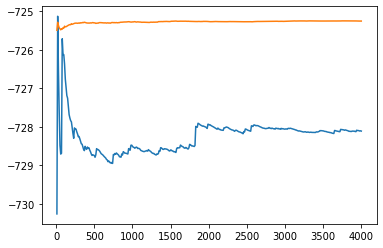

In [44]:
aic_y = sweep_res_aic_waic['AIC'].apply(lambda x: x['value'])
waic_y = sweep_res_aic_waic['WAIC'].apply(lambda x: x['value'])
many_samples = sweep_res_aic_waic['samples']
plt.plot(many_samples, waic_y)
plt.plot(many_samples, aic_y)

In [ ]:
stability_models = initialise_models(samples=samples+warmup)
fast_model = stability_models[4]

In [39]:
sweep_res_dic = metrics_refactored.sweep_samples(fast_model, data, warmup=warmup, metrics={'DIC':metrics_refactored.dic}, points=40)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
100%|██████████| 40/40 [17:43<00:00, 26.59s/it]


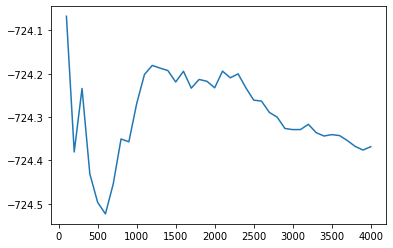

In [42]:
dic_y = sweep_res_dic['DIC'].apply(lambda x: x['value'])
dic_samples = sweep_res_dic['samples']
plt.plot(dic_samples, dic_y)

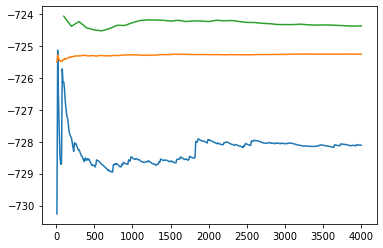

In [45]:
plt.plot(many_samples, waic_y)
plt.plot(many_samples, aic_y)
plt.plot(dic_samples, dic_y)

In [82]:
samples = 4000
stability_models = initialise_models(samples=samples+warmup)
fast_model = stability_models[4]
fast_model.fit(datasets['A'], control=fit_kwargs, warmup=warmup)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [83]:
sweep_res_mape = metrics_refactored.defalut_cross_val_sweepable(fast_model, warmup=warmup, points=40)

100%|██████████| 40/40 [23:34<00:00, 35.35s/it]


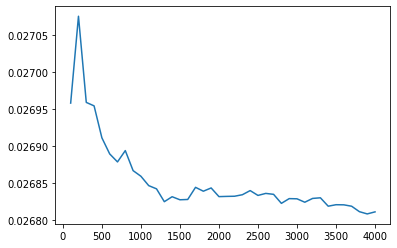

In [86]:
mape_y = sweep_res_mape['MAPE'].apply(lambda x: x['value']['mape'])
mape_samples = sweep_res_mape['samples']
plt.plot(mape_samples, mape_y)

In [92]:
samples = 4000
stability_models = initialise_models(samples=samples+warmup)
fast_model = stability_models[4]
fast_model.fit(datasets['A'], control=fit_kwargs, warmup=warmup)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
sweep_results_k_fold = metrics_refactored.k_fold_loo_cv_sweepable(fast_model, points=400, max_samples=samples)

Fitting 0/10
Fitting 1/10
Fitting 2/10
Fitting 3/10
Fitting 4/10
Fitting 5/10
Fitting 6/10
Fitting 7/10
Fitting 8/10
Fitting 9/10
100%|██████████| 400/400 [47:02<00:00,  7.06s/it]


In [96]:
k_fold_y = sweep_results_k_fold['lppd_cloo_cv']
k_fold_samples = sweep_results_k_fold['samples']

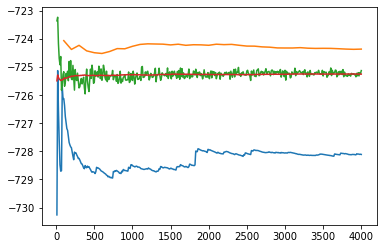

In [103]:

plt.plot(many_samples, waic_y)
plt.plot(dic_samples, dic_y)
plt.plot(k_fold_samples, k_fold_y*-2)
plt.plot(many_samples, aic_y)

# Save data and make plots

---

In [116]:
df_400 = pd.DataFrame({'AIC': aic_y, 'WAIC': waic_y, '10-fold CV': k_fold_y})
df_400.index = k_fold_samples
df_40 = pd.DataFrame({'DIC': dic_y, 'MAPE': mape_y.iloc[:,0]})
df_40.index = dic_samples
df_400.to_csv('../tables/stability/400.csv')
df_40.to_csv('../tables/stability/40.csv')

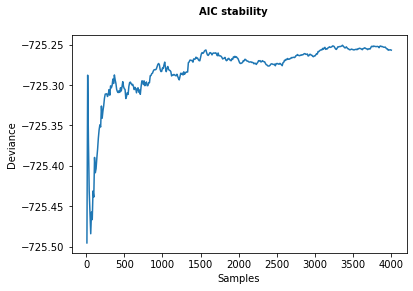

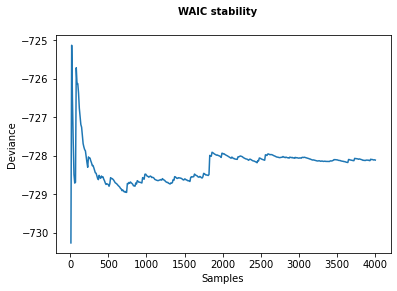

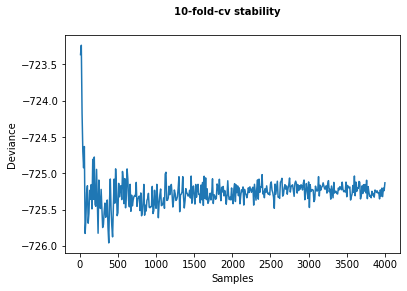

In [146]:
for name, y in {'AIC': aic_y, 'WAIC': waic_y, '10-fold-cv': -2*k_fold_y}.items():
    fig, ax = plt.subplots()
    ax.plot(df_400.index, y)
    ax.set_ylabel('Deviance')
    ax.set_xlabel('Samples')
    fig.suptitle(f'{name} stability', size=10, fontweight='bold')
    plt.show()

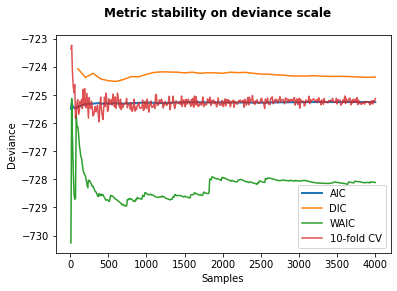

In [158]:
fig, ax = plt.subplots()
ax.plot(many_samples, aic_y, linewidth=2)
ax.plot(dic_samples, dic_y)
ax.plot(many_samples, waic_y)
ax.plot(many_samples, k_fold_y*-2, alpha=0.8)
ax.set_ylabel('Deviance')
ax.set_xlabel('Samples')
ax.legend(['AIC', 'DIC', 'WAIC', '10-fold CV'])
fig.suptitle('Metric stability on deviance scale', size=12, fontweight='bold')
plt.savefig('../plots/stability/metric_stability.pdf')
plt.show()


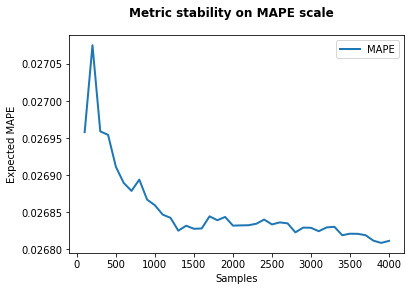

In [161]:
fig, ax = plt.subplots()
ax.plot(mape_samples, mape_y, linewidth=2)
ax.set_ylabel('Expected MAPE')
ax.set_xlabel('Samples')
ax.legend(['MAPE'])
fig.suptitle('Metric stability on MAPE scale', size=12, fontweight='bold')
plt.savefig('../plots/stability/metric_stability_MAPE.pdf')
plt.show()